<table border="0" width="100%"><p align="left"><img src="logo.png"  align="left" width=30%></table>

# <center>Chapter 5 文本数据增强</center>

**数据增强可以简单理解为由少量数据生成大量数据的过程。一般比较成功的神经网络拥有大量参数，使这些参数正确工作需要用大量的数据进行训练，但实际情况中数据并没有那么多，因此需要做数据增强。相较于图像、语音方面的数据增强而言，文本的数据增强更具有挑战性，因为文本中微小的改动就可能带来语义的变化，从而破坏了原文本，导致数据质量降低。本章将介绍通用几种文本数据增强方法，除了这些通用的增强方法之外，大多数时候需要针对具体的NLP任务设计对应的文本数据增强方法。**
###  本章节基本组织如下:
* 文本截断
* 文本数据扩充
* 噪声技术(EDA)

**给出example data并进行基本的数据分析**

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('example_text_data.csv')
print(f"data.shape: {data.shape}")
display(data.head())

data.shape: (600, 2)


,id,text
0,2401,"活动二：消费满额加送两次代驾服务,2022年1月1日至12月31日，首次成功办理家庭卡银联版..."
1,2402,消费越多，里程越多3.高额航空保险对于经常处于旅行奔波的人士来说，出行安全及有关保障是其考虑...
2,2403,"温馨提示：新办卡客户消费达标后可同时参与上述两个赠礼活动,刷卡满200元享118元返现:20..."
3,2404,该卡为银联单币种信用卡，具有新一代长城信用卡所有功能中银海西文化信用卡是长城品牌下面向福建本...
4,2405,"（2）航班及行李延误险,使用家庭卡银联版支付本人100%国内外机票款（含折扣机票款）或100..."


**对于纯文本数据而言，一般我们关注的是需不需要做数据清洗和文本长度两个方面。具体的文本数据清洗方法可参照第一章节，我们先对文本长度进行分析**

In [3]:
data['text_len'] = data['text'].map(len)   # 使用map方法对data的text列的所有值计算长度，并生成一个新列text_len
display(data.head())

,id,text,text_len
0,2401,"活动二：消费满额加送两次代驾服务,2022年1月1日至12月31日，首次成功办理家庭卡银联版...",100
1,2402,消费越多，里程越多3.高额航空保险对于经常处于旅行奔波的人士来说，出行安全及有关保障是其考虑...,141
2,2403,"温馨提示：新办卡客户消费达标后可同时参与上述两个赠礼活动,刷卡满200元享118元返现:20...",175
3,2404,该卡为银联单币种信用卡，具有新一代长城信用卡所有功能中银海西文化信用卡是长城品牌下面向福建本...,111
4,2405,"（2）航班及行李延误险,使用家庭卡银联版支付本人100%国内外机票款（含折扣机票款）或100...",145


<AxesSubplot:>

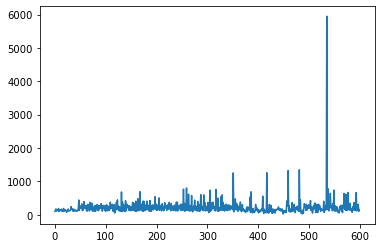

In [4]:
data['text_len'].plot()   # 观察一下文本长度的数据分布

In [5]:
data['text_len'].describe()  # describe方法数据较为全面的分析

count     600.0000
mean      223.5000
std       281.2513
min        25.0000
25%       121.0000
50%       163.0000
75%       268.2500
max      5949.0000
Name: text_len, dtype: float64

**可以看到大部分文本长度在300以内，存在少量超长文本。一般而言，为了避免维度过大以及提升计算效率，大多数NLP模型将文本的输入长度限制在了512或1024之内，这就意味着对于少量的超长文本，需要抛弃或者进行文本截断操作**

## 1.文本数据截断

**在处理长文本的过程中，通常需要按照某个阈值对文本进行截断，但是又不能直接去在当前阈值截断，可能会破坏句子结构，比较理想的方案是在某一个阈值向前搜索并找到句子的末位（例如句号）处进行截断，剩下的若还超过阈值，则重复截断。**

<center><img src="文本截断.jpg" width=80%><center>

In [6]:
truncated_data = pd.DataFrame(columns=['id','text'])  #新建dataframe
max_len = 300  #假设句子最长为300

for j in range(len(data)):  
    text = data['text'][j]  #text
    left_index = 0          #设定句子的左索引，默认为0
    temp_text_list = []     #list
    count = 0
    df = {}    #存放新增的内容
   
    while len(text[left_index:])>= max_len :
        count +=1
        for z in range(100):  # 只需向前搜索一定步数，加快运算
            if text[left_index+max_len-z] in ['！','。','>','；','•','）'] :  #出现list里的这些符号认为为句子末尾，可自定义
                temp_text_list.append(text[left_index: left_index+300-z+1])   #截断的第一个句子
                
                left_index += max_len-z+1  # 将左索引右移到截断处

                break
        if count>=40:  #可能会出现长文本里面没有结尾的情况，限制搜索范围为max_len*40个字节
            break
    
    temp_text_list.append(text[left_index:])  #截断的句子存放处
    
    for i in temp_text_list:  #遍历每个被截断的句子
        
        df["id"] = data['id'][j]  #装入df
        df["text"] = i
        
        truncated_data = truncated_data.append(df,ignore_index=True)  # 向dataframe内添加行

In [34]:
truncated_data['text_len'] = truncated_data['text'].map(len)
truncated_data['text_len'].describe()   # 文本长度的数据分布

count     708.000000
mean      189.406780
std       183.186578
min        10.000000
25%       120.000000
50%       161.000000
75%       254.000000
max      4266.000000
Name: text_len, dtype: float64

## 2.数据扩充

**深度学习模型需要足够的数据支撑才能进行更好地训练，但实际生活中，作为开发者往往无法获取大量的数据，而专业的数据采集和标注公司提供的数据服务也并不便宜，因此，解决此问题有一个较为不错的初级方案，那就是进行数据扩充。数据扩充（data augmentation）其本质即：缺少海量数据时，为了保证模型的有效训练，一分钱掰成两半花。
这里介绍两种数据扩充的方法：**

### 2.1直接复制（python copy()等方法的使用和解释）

**Python中,直接用等于符号或者运用copy()函数可以返回一个复制，然而单纯地运用等于符号和copy()函数,只会返回一个浅复制(浅拷贝)，对于浅复制而言，其中一个发生变化，另一个被复制的对象或原对象也会发生变化。**

**而对于深复制(深拷贝)而言，一旦复制出来了，就是独立的，其中一个发生变化，另一个不会随之发生变化**

In [21]:
df = pd.DataFrame([[1,2,3]],columns=["a","b","c"])  # 生成一个df
print(f"原df:\n{df}")

df1 = df   #浅
print(f"浅复制df:\n{df1}")

df2 = df.copy(deep=False)  #浅
print(f"浅复制df:\n{df2}")

df3 = df.copy(deep=True)  #深
print(f"深复制df:\n{df3}")

原df:
   a  b  c
0  1  2  3
浅复制df:
   a  b  c
0  1  2  3
浅复制df:
   a  b  c
0  1  2  3
深复制df:
   a  b  c
0  1  2  3


In [22]:
df["a"][0] = 999  # 改变原df的值
print(f"原df:\n{df}")   
print(f"浅复制df:\n{df1}")    #随着改变
print(f"浅复制df:\n{df2}")    #随着改变
print(f"深复制df:\n{df3}")    #不改变

原df:
     a  b  c
0  999  2  3
浅复制df:
     a  b  c
0  999  2  3
浅复制df:
     a  b  c
0  999  2  3
深复制df:
   a  b  c
0  1  2  3


**因此，增加数据量最简单和直接的方法就是直接复制拷贝一份新的数据**

In [23]:
import pandas as pd
data = pd.read_csv('example_text_data.csv')
print(f"原数据data.shape: {data.shape}")
display(data.head())   

原数据data.shape: (600, 2)


,id,text
0,2401,"活动二：消费满额加送两次代驾服务,2022年1月1日至12月31日，首次成功办理家庭卡银联版..."
1,2402,消费越多，里程越多3.高额航空保险对于经常处于旅行奔波的人士来说，出行安全及有关保障是其考虑...
2,2403,"温馨提示：新办卡客户消费达标后可同时参与上述两个赠礼活动,刷卡满200元享118元返现:20..."
3,2404,该卡为银联单币种信用卡，具有新一代长城信用卡所有功能中银海西文化信用卡是长城品牌下面向福建本...
4,2405,"（2）航班及行李延误险,使用家庭卡银联版支付本人100%国内外机票款（含折扣机票款）或100..."


In [24]:
new_data  = data.copy(deep=True)  # 深复制
data = pd.concat([new_data,data], ignore_index = True)  #pd.concat将两个dataframe进行拼合
print(f"扩充后的数据data.shape: {data.shape}")
display(data.head())

扩充后的数据data.shape: (1200, 2)


,id,text
0,2401,"活动二：消费满额加送两次代驾服务,2022年1月1日至12月31日，首次成功办理家庭卡银联版..."
1,2402,消费越多，里程越多3.高额航空保险对于经常处于旅行奔波的人士来说，出行安全及有关保障是其考虑...
2,2403,"温馨提示：新办卡客户消费达标后可同时参与上述两个赠礼活动,刷卡满200元享118元返现:20..."
3,2404,该卡为银联单币种信用卡，具有新一代长城信用卡所有功能中银海西文化信用卡是长城品牌下面向福建本...
4,2405,"（2）航班及行李延误险,使用家庭卡银联版支付本人100%国内外机票款（含折扣机票款）或100..."


### 2.2反译

**对于文本数据而言，将文本翻译成其他语言再翻译成回来后，利用翻译器的特点，使得翻译回来的文本与原来的文本语义高度相似，又引入了其他词汇，增加了模型可学习的内容。**

**[googletrans](https://github.com/ssut/py-googletrans//)是一个免费的调用谷歌翻译库的python api,可以通过以下代码安装：**

In [ ]:
!pip install googletrans==4.0.0rc1

**利用[gooletrans](https://github.com/ssut/py-googletrans//)来进行中文的反译操作：**

In [26]:
import csv
from googletrans import Translator

translator = Translator(service_urls=[ 
      'translate.google.cn' 
    ]) #接入谷歌的翻译服务，设定service_urls为translate.google.cn即可翻译中文

translator.raise_Exception = True  # 避免ip被限制

chinese_text = '下面的代码，我只涉及到了“中文”和“英语”两种语言的循环翻译，没有涉及到其他的语言。'
print(f"原句子: \n{chinese_text}\n")

english_text = translator.translate(chinese_text).text  # 调用translate方法
print(f"汉译英: \n{english_text}\n")

re_chinese_text = translator.translate(english_text,dest='zh-CN').text  # 设定为英译汉
print(f"英译汉:\n{re_chinese_text}\n")

原句子: 
下面的代码，我只涉及到了“中文”和“英语”两种语言的循环翻译，没有涉及到其他的语言。

汉译英: 
In the following code, I only involve cyclic translations of two languages: "Chinese" and "English", which does not involve other languages.

英译汉:
在以下代码中，我仅涉及两种语言的循环翻译：“中文”和“英语”，不涉及其他语言。



**将example_data进行批量的反译：**

In [27]:
import pandas as pd
data = pd.read_csv('example_text_data.csv')  # 读入

trans_data = data.copy(deep = True)  #深拷贝

translator.raise_Exception = True   # 避免ip被限制

trans_data['trans_text'] = trans_data['text'][:5].map(lambda x: translator.translate(translator.translate(x).text,dest='zh-CN').text)
# map和lambda函数是dataframe中非常重要的函数，可以很方便的灵活的对dataframe进行批量操作
display(trans_data.head())

,id,text,trans_text
0,2401,"活动二：消费满额加送两次代驾服务,2022年1月1日至12月31日，首次成功办理家庭卡银联版...",活动2：全面消费并发送两项驾驶服务。从2022年1月1日到12月31日，首次成功地应用了家用...
1,2402,消费越多，里程越多3.高额航空保险对于经常处于旅行奔波的人士来说，出行安全及有关保障是其考虑...,消费越多，里程越多。3.对于那些经常旅行，旅行安全和相关保证的人来说，高空保险是其考虑的主要...
2,2403,"温馨提示：新办卡客户消费达标后可同时参与上述两个赠礼活动,刷卡满200元享118元返现:20...",提醒：新的卡客户消费达到标准后，您可以同时参与上述两个礼物。通过CCB移动银行，“中国Chi...
3,2404,该卡为银联单币种信用卡，具有新一代长城信用卡所有功能中银海西文化信用卡是长城品牌下面向福建本...,该卡是UnionPay的一张货币信用卡。它具有新一代大墙信用卡，所有功能在大墙信用卡的所有功...
4,2405,"（2）航班及行李延误险,使用家庭卡银联版支付本人100%国内外机票款（含折扣机票款）或100...",（2）航班和行李延迟保险，使用家用卡Unionpay版本支付100％的国内和外国票证资金（包...


**注：由于googletrans本质上是一种网络爬虫访问方法，所以在进行高频的操作时有会被网络限制(404),可以尝试更换ip地址或者利用for循环加上time.sleep()函数单笔地进行操作。如果要用于商业化或者实操于大规模数据集，建议购买谷歌官方的翻译API服务。**

## 3.噪声技术

**噪声技术旨在通过向文本中注入噪声数据，来生成新的文本，最后使得训练的模型对扰动具有鲁棒性。EDA（Easy Data Augmentation）是一种通用且易于实现的nlp噪声技术，[EDA](https://github.com/jasonwei20/eda_nlp//) 由四个简单但功能强大的操作组成：同义词替换、随机插入、随机交换和随机删除。在论文 [《EDA: Easy Data Augmentation Techniques for Boosting Performance on Text Classification Tasks》](https://arxiv.org/abs/1901.11196//)中，作者用五个文本分类任务中证明了EDA显著提高了卷积和递归神经网络的性能，仅使用 50% 的可用训练集进行 EDA 训练便达到了与使用所有可用数据进行正常训练相同的准确度。**


### 3.1   同义词替换

**同义词替换(Synonym Replacement, SR)是指从句子中随机选取n个不属于非停止词，并随机选择其同义词替换它们**

<center><img src="https://img-blog.csdnimg.cn/20200923194604909.png#pic_center" width=60%><center>






In [ ]:
!pip install synonyms #若未安装synonoyms,运行此代码，若synonyms安装错误，请检查是否有安装jieba等前置库

In [1]:
import jieba
import random
from random import shuffle
import sys
import synonyms 
#一个中文近义词工具包，开源地址在https://github.com/chatopera/Synonyms
#synonyms第一次调包可能会很慢，您可以选择将文件夹中的"words.vector.gz"文件放入该包路径".//synonyms//data//"中,
#以anaconda为例，路径为应该为"//anaconda//lib//site-packages//synonyms//data//"

Building prefix dict from D:\anacondaset\lib\site-packages\synonyms\data\vocab.txt ...
Loading model from cache C:\Users\14331\AppData\Local\Temp\jieba.u0775d9f1bbd4cda6d36b68c0c04220ec.cache



 Synonyms: v3.18.0, Project home: https://github.com/chatopera/Synonyms/

 Project Sponsored by Chatopera

  deliver your chatbots with Chatopera Cloud Services --> https://bot.chatopera.com

>> Synonyms load wordseg dict [D:\anacondaset\lib\site-packages\synonyms\data\vocab.txt] ... 


Loading model cost 1.028 seconds.
Prefix dict has been built successfully.


>> Synonyms on loading stopwords [D:\anacondaset\lib\site-packages\synonyms\data\stopwords.txt] ...
>> Synonyms on loading vectors [D:\anacondaset\lib\site-packages\synonyms\data\words.vector.gz] ...


**我们通过synonyms.display()和synonyms.nearby()来具体看一下synonyms是怎么展示中文同义词结果。**

In [2]:
synonyms.display("飞机") #synonyms.display()将输出"飞机"的近义词组，并以单词相似性由高到低排序

'飞机'近义词：
  1. 飞机:1.0
  2. 直升机:0.842339
  3. 客机:0.8393002
  4. 滑翔机:0.78723866
  5. 军用飞机:0.78320795
  6. 水上飞机:0.7785722
  7. 运输机:0.7724741
  8. 航机:0.76647466
  9. 航空器:0.7659289
  10. 民航机:0.74209636


In [3]:
synonyms.nearby("飞机") #synonyms.nearby()返回一个包含"近义词"和"该近义词得分"的元组，二者均以列表的形式存储

(['飞机', '直升机', '客机', '滑翔机', '军用飞机', '水上飞机', '运输机', '航机', '航空器', '民航机'],
 [1.0,
  0.842339,
  0.8393002,
  0.78723866,
  0.78320795,
  0.7785722,
  0.7724741,
  0.76647466,
  0.7659289,
  0.74209636])

**注：除了synonyms库之外，还可以通过各种方式构建任务的同义词库，例如前几章介绍的TFidf和word2vec方法，或者是根据自身的先验知识人为的构造。**

**接下来我们将利用同义词库去构建EDA中的相关方法，包括同义词替换和随机插入。在这之前我们可以复习一下第二章我们所学的文本预处理知识，特别是如何构建停用词列表，如何进行文本分词:**

In [4]:
random.seed(2022) #设置随机种子

#构建停用词列表
with open('停用词.txt', 'r',encoding='utf-8') as f:   
    stop_words = [s.rstrip() for s in f.readlines()]

print(stop_words[0:15])

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '--', '.']


In [5]:
#分词
sentence = "我也期待着能和你飞去同一片土地"
words = jieba.lcut(sentence)  # 调用jieba进行分词
print(words)  # 分词结果

['我', '也', '期待', '着', '能', '和', '你', '飞去', '同', '一片', '土地']


**进行同义词替换主要只进行二步，第一步是找到同义词列表，第二部是随机选择同义词列表中的一个词进行替换**

In [6]:
# 同义词替换：替换一个语句中的n个单词为其同义词

def get_synonyms(word):  # 给定一个词，返回一个列表，包含该词的10个意思最相近的词语
    return synonyms.nearby(word)[0] #synonyms.nearby()[0],即列表

def synonym_replacement(words, n):
    new_words = words.copy()  # 深拷贝
    random_word_list = list(set([word for word in words if word not in stop_words])) #生成非停止词列表    
    random.shuffle(random_word_list) #将列表中元素打乱顺序，便于后续随机选择同义词进行替换
    num_replaced = 0      #被替换的词的数量，初始为0  
    
    for random_word in random_word_list:          
        synonyms = get_synonyms(random_word) #调用刚才定义的函数get_synonyms，返回意思最相近的词语
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms) #在同义词列表中随机选择一个同义词  
            new_words = [synonym if word == random_word else word for word in new_words] #将随机选择的同义词添加进词表，并替换原单词  
            num_replaced += 1
        if num_replaced >= n: #当n个单词被替换后结束循环
            break

    

    return new_words

In [7]:
print(f"替换前:\n{words}\n")
print(f"替换后:\n{synonym_replacement(words, 1)}\n")  #调用synonym_replacement，设置n=1，即随机替换一个同义词

替换前:
['我', '也', '期待', '着', '能', '和', '你', '飞去', '同', '一片', '土地']

替换后:
['我', '也', '期待', '着', '能', '和', '你', '飞去', '同', '一片', '国有土地']



### 3.2   随机插入

**随机插入（Random Insertion，RI）是指从句子中随机选择一个非停止词，然后找到它对应的同义词，并将其插入到句子中的一个随机位置**

<center><img src="https://pic4.zhimg.com/80/v2-07e91e2ad12265da5ab6e5271c99f043_720w.jpg" width=60%><center>

In [8]:
# 随机插入n个同义词

def add_word(new_words):
    synonyms = []  # 同义词表
    counter = 0  # 计数器
    random_word_list = list(set([word for word in new_words if word not in stop_words])) #生成非停止词列表   
    while len(synonyms) < 1:
        #这里主要指随机选择random_word_list中一个词
        random_word = random_word_list[random.randint(0, len(random_word_list)-1)] #random.randint()方法随机返回指定范围内的一个整数，并且可以取到右侧边界值，为防止索引超出列表容量，因此会减1
        synonyms = get_synonyms(random_word) #调用上面定义的函数get_synonyms，返回一个包含10个同义词的list
        counter += 1
        if counter >= 10:
            return
    random_synonym = random.choice(synonyms)  # 从同义词中随机进行选择
    random_idx = random.randint(0, len(new_words)-1) #选择一个随机索引，便于随机选择的同义词插入
    new_words.insert(random_idx, random_synonym)  #在随机索引处插入同义词


def random_insertion(words, n):   #调用随机插入方法，重复n次
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words) # 调用上面定义的函数add_word
    return new_words

In [9]:
print(f"插入前:\n{words}\n")
print(f"插入后:\n{random_insertion(words, 1)}\n") #随机插入n =1个同义词

插入前:
['我', '也', '期待', '着', '能', '和', '你', '飞去', '同', '一片', '土地']

插入后:
['我', '也', '期待', '着', '能', '和', '你', '飞去', '同', '盼望', '一片', '土地']



### 3.3   随机交换

**随机插入（Random Swap,RS）是指在句子中随机交换任意n组单词的位置。**

<center><img src="https://pic1.zhimg.com/80/v2-6f36ba1a0757ca2ab837b7c5b1b082ac_720w.png" width=60%><center>

In [10]:
#随机交换n次单词
def swap_word(new_words):   # 交换单词
    while(len(new_words)>=2):  #至少有两个单词才能进行交换
        random_idx_1 = random.randint(0, len(new_words)-1)  #生成一个随机索引
        random_idx_2 = random.randint(0, len(new_words)-1) 
        if random_idx_1 !=  random_idx_2:  # 当且仅当两个随机索引不相等时
            new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]  #根据生成的索引进行单词交换
            break
    
    return new_words

def random_swap(words, n):  #调用交换单词方法，并重复n次
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words) #调用函数swap_word
    return new_words

In [11]:
print(f"交换前:\n{words}\n")
print(f"交换后:\n{random_swap(words, 1)}\n")#随机交换一组单词

交换前:
['我', '也', '期待', '着', '能', '和', '你', '飞去', '同', '一片', '土地']

交换后:
['同', '也', '期待', '着', '能', '和', '你', '飞去', '我', '一片', '土地']



### 3.3   随机删除

**随机删除（Random Deletion，RD）指以概率p随机删除句子中的单词。**

<center><img src="https://pic1.zhimg.com/80/v2-1882dba089891493b3bcec075e9a1f48_720w.jpg" width=60%><center>

In [12]:
#随机删除：以概率p删除words中的词组

def random_deletion(words, p):

    if len(words) == 1:  # 至少要大于1个单词才能随机删除
        return words

    new_words = []
    for word in words:
        r = random.uniform(0, 1) #随机生成一个在（0，1）范围内的实数
        if r > p: #以1-p的概率向新词列表添加单词
            new_words.append(word)

    if len(new_words) == 0: #若删除概率p为1，则随机保留词表中的一个单词
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    return new_words

In [13]:
print(f"删除前:\n{words}\n")
print(f"删除后:\n{random_deletion(words, 0.1)}\n") #以0.1的概率随机删除单词

删除前:
['我', '也', '期待', '着', '能', '和', '你', '飞去', '同', '一片', '土地']

删除后:
['我', '也', '期待', '着', '能', '和', '你', '飞去', '同', '一片', '土地']



**下面我们将以上四个方法进行封装，方便后续调用来进行文本数据增强**

In [14]:
with open('停用词.txt', 'r',encoding='utf-8') as f:   
    stop_words = [s.rstrip() for s in f.readlines()]

In [19]:
class EDA(object):
    
    def __init__(self, stop_words, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1):
        #alpha_sr、alpha_ri、alpha_rs和p_rd分别是四种噪声技术的参数，可以理解某技术更改的单词的百分比,初始默认值根据EDA论文设定
        self.stop_words = stop_words
        self.alpha_sr = alpha_sr
        self.alpha_ri = alpha_ri
        self.alpha_rs = alpha_rs
        self.p_rd = p_rd
        
    # 同义词替换
    def synonym_replacement(self,sentence):
        
        words = jieba.lcut(sentence)
        
        num_words = len(words)
        n_sr = max(1, int(self.alpha_sr * num_words))  #设置句子和单词的噪声强度  
        
        new_words = words.copy()  # 深拷贝
        
        random_word_list = list(set([word for word in words if word not in self.stop_words])) #生成非停止词列表    
        random.shuffle(random_word_list) #将列表中元素打乱顺序，便于后续随机选择同义词进行替换
        num_replaced = 0      #被替换的词的数量，初始为0  

        for random_word in random_word_list:          
            synonyms_word = synonyms.nearby(random_word)[0] #调用刚才定义的函数get_synonyms，返回意思最相近的词语
            if len(synonyms_word) >= 1:
                synonym = random.choice(synonyms_word) #在同义词列表中随机选择一个同义词  
                new_words = [synonym if word == random_word else word for word in new_words] #将随机选择的同义词添加进词表，并替换原单词  
                num_replaced += 1
            if num_replaced >= n_sr: #当n个单词被替换后结束循环
                break
        new_sentence = ''.join(str(i) for i in new_words)
        return new_sentence
    
    # 随机插入
    def random_insertion(self,sentence):
        
        words = jieba.lcut(sentence)
        num_words = len(words)
        n_ri = max(1, int(self.alpha_ri * num_words)) #设置句子和单词的噪声强度  
        new_words = words.copy()  # 深拷贝
        for _ in range(n_ri):
            synonyms_word = []  # 同义词表
            counter = 0  # 计数器
            random_word_list = list(set([word for word in new_words if word not in stop_words])) #生成非停止词列表   
            while len(synonyms_word) < 1:
                #这里主要指随机选择random_word_list中一个词
                random_word = random_word_list[random.randint(0, len(random_word_list)-1)] #random.randint()方法随机返回指定范围内的一个整数，并且可以取到右侧边界值，为防止索引超出列表容量，因此会减1
                synonyms_word = synonyms.nearby(random_word)[0] #调用synonyms，返回一个包含10个同义词的list
                counter += 1
                if counter >= 10:
                    return
            random_synonym = random.choice(synonyms_word)  # 从同义词中随机进行选择
            random_idx = random.randint(0, len(new_words)-1) #选择一个随机索引，便于随机选择的同义词插入
            new_words.insert(random_idx, random_synonym)  #在随机索引处插入同义词
        
        new_sentence = ''.join(str(i) for i in new_words)
        return new_sentence
    
    # 随机交换
    def random_swap(self,sentence):   # 交换单词
        
        words = jieba.lcut(sentence)
        num_words = len(words)
        n_rs = max(1, int(self.alpha_rs * num_words)) #设置句子和单词的噪声强度  
        new_words = words.copy()  # 深拷贝
        
        for _ in range(n_rs):
            while(len(new_words)>=2):  #至少有两个单词才能进行交换
                random_idx_1 = random.randint(0, len(new_words)-1)  #生成一个随机索引
                random_idx_2 = random.randint(0, len(new_words)-1) 
                if random_idx_1 !=  random_idx_2:  # 当且仅当两个随机索引不相等时
                    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]  #根据生成的索引进行单词交换
                    break

        new_sentence = ''.join(str(i) for i in new_words)
        return new_sentence
    
    # 随机删除
    def random_deletion(self,sentence):
        
        words = jieba.lcut(sentence)

        if len(words) == 1:  # 至少要大于1个单词才能随机删除
            return words

        new_words = []
        for word in words:
            r = random.uniform(0, 1) #随机生成一个在（0，1）范围内的实数
            if r > self.p_rd: #以1-p_rd的概率向新词列表添加单词
                new_words.append(word)

        if len(new_words) == 0: #若删除概率p为1，则随机保留词表中的一个单词
            rand_int = random.randint(0, len(words)-1)
            return [words[rand_int]]
        
        new_sentence = ''.join(str(i) for i in new_words)
        return new_sentence
        
        
    

In [20]:
eda = EDA(stop_words)  # 实例化 EDA
sentence = '我也希望着能和你飞去同一片土地'
print(f"原句子:\n{sentence}\n")
print(f"同义词替换:\n{eda.synonym_replacement(sentence)}\n")
print(f"随机交换:\n{eda.random_swap(sentence)}\n")
print(f"随机插入:\n{eda.random_insertion(sentence)}\n")
print(f"随机删除:\n{eda.random_deletion(sentence)}\n")

原句子:
我也希望着能和你飞去同一片土地

同义词替换:
我也希望着能和你直奔同一片土地

随机交换:
我你希望着能和也飞去同一片土地

随机插入:
我也希望着能和你飞去同一片期望土地

随机删除:
我也希望着和你飞去同一片土地



**尝试批量化的使用EDA方法并应用于example_data中**

In [53]:
import pandas as pd
data = pd.read_csv('example_text_data.csv')

with open('停用词.txt', 'r',encoding='utf-8') as f:   
    stop_words = [s.rstrip() for s in f.readlines()]

eda = EDA(stop_words)  # 实例化 EDA

data['EDA_随机删除'] = data['text'].map(lambda x: eda.random_deletion(x))
# map和lambda函数是dataframe中非常重要的函数，可以很方便的灵活的对dataframe进行批量操作
display(data.head())

,id,text,EDA_随机删除
0,2401,"活动二：消费满额加送两次代驾服务,2022年1月1日至12月31日，首次成功办理家庭卡银联版...","活动二：满额加送两次服务,2022年1日至12月31日，首次成功办理家庭卡银联版的主人非、支..."
1,2402,消费越多，里程越多3.高额航空保险对于经常处于旅行奔波的人士来说，出行安全及有关保障是其考虑...,消费越多，里程越多3高额航空保险对于处于旅行奔波人士来说，出行安全及有关保障是其考虑的因素作...
2,2403,"温馨提示：新办卡客户消费达标后可同时参与上述两个赠礼活动,刷卡满200元享118元返现:20...","温馨：新办卡客户消费达标后可同时参与两个赠礼,满200118元返现:2021年5月日-年4月..."
3,2404,该卡为银联单币种信用卡，具有新一代长城信用卡所有功能中银海西文化信用卡是长城品牌下面向福建本...,该卡为银联单币种信用卡，具有新一代功能中银海西文化信用卡是长城品牌下面向本土文化产业开发的细...
4,2405,"（2）航班及行李延误险,使用家庭卡银联版支付本人100%国内外机票款（含折扣机票款）或100...","（2）航班及行李延误险,使用家庭卡版支付本人100%国内外款（含机票款）或旅行团费（需含飞机..."


In [54]:
print(f"删除前:\n{data.iloc[0].text}\n")
print(f"删除后:\n{data.iloc[0].EDA_随机删除}\n")

删除前:
活动二：消费满额加送两次代驾服务,2022年1月1日至12月31日，首次成功办理家庭卡银联版的主卡持卡人非微信、支付宝消费满1万元，即可额外获赠2次同城单程50公里内免费代驾服务，限量1万份，先到先得

删除后:
活动二：满额加送两次服务,2022年1日至12月31日，首次成功办理家庭卡银联版的主人非、支付宝满1万元，即可额外获赠2同城单程50公里内免费代驾服务，限量1万份，先到先得

